In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Creating multiple dataframe with different "look back" periods
# The periods are 1 day, 3 days. 7 days. 15 days. 30 days and 60 days
# The look back periods should be in the form of a list
# For example, if the look back period is 3, then the dataframe should have 3 columns
# Date, Close, [Close(t-1), Close(t-2), Close(t-3)]

def create_look_back_arrays(df, window_size = 1):
    df = df.drop(columns = ['Date'])
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i+window_size])
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [3]:
df = pd.read_csv('../Data/bitcoin_data.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3174,2023-05-27,26720.181641,26888.882812,26621.140625,26868.353516,26868.353516,7892015141
3175,2023-05-28,26871.158203,28193.449219,26802.751953,28085.646484,28085.646484,14545229578
3176,2023-05-29,28075.591797,28432.039062,27563.876953,27745.884766,27745.884766,15181308984
3177,2023-05-30,27745.123047,28044.759766,27588.501953,27702.349609,27702.349609,13251081851


In [5]:
df = df[['Date', 'Close']]

In [6]:
df

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3174,2023-05-27,26868.353516
3175,2023-05-28,28085.646484
3176,2023-05-29,27745.884766
3177,2023-05-30,27702.349609


In [7]:
# Scale the values in the Close column
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

/var/folders/76/w363ly_90ln6pf3txlrc64bw0000gn/T/ipykernel_70206/3875126601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [8]:
df

,Date,Close
0,2014-09-17,0.004144
1,2014-09-18,0.003655
2,2014-09-19,0.003216
3,2014-09-20,0.003425
4,2014-09-21,0.003275
...,...,...
3174,2023-05-27,0.396064
3175,2023-05-28,0.414128
3176,2023-05-29,0.409086
3177,2023-05-30,0.408440


In [9]:
x_1, y_1 = create_look_back_arrays(df, 1)
x_3, y_3 = create_look_back_arrays(df, 3)
x_7, y_7 = create_look_back_arrays(df, 7)
x_15, y_15 = create_look_back_arrays(df, 15)
x_30, y_30 = create_look_back_arrays(df, 30)
x_60, y_60 = create_look_back_arrays(df, 60)

# 1 Day look back window

In [10]:
x_1.shape, y_1.shape

((3178, 1, 1), (3178, 1))

In [11]:
X_1_train, y_1_train = x_1[:int(0.8*len(x_1))], y_1[:int(0.8*len(x_1))]
X_1_val, y_1_val = x_1[int(0.8*len(x_1)):int(0.9*len(x_1))], y_1[int(0.8*len(x_1)):int(0.9*len(x_1))]
X_1_test, y_1_test = x_1[int(0.9*len(x_1)):], y_1[int(0.9*len(x_1)):]
X_1_train.shape, y_1_train.shape, X_1_val.shape, y_1_val.shape, X_1_test.shape, y_1_test.shape

((2542, 1, 1), (2542, 1), (318, 1, 1), (318, 1), (318, 1, 1), (318, 1))

In [12]:
model_1 = Sequential()
model_1.add(InputLayer(input_shape = (1, 1)))
model_1.add(GRU(64))
model_1.add(Dense(8, activation = 'relu'))
model_1.add(Dense(1, activation = 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('models/gru_1.h5', save_best_only = True)
model_1.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [14]:
model_1.fit(X_1_train, y_1_train, epochs = 200, validation_data = (X_1_val, y_1_val), callbacks = [cp])

Epoch 1/200
80/80 [==============================] - 1s 3ms/step - loss: 0.0354 - root_mean_squared_error: 0.1883 - mean_absolute_error: 0.1017 - val_loss: 0.2511 - val_root_mean_squared_error: 0.5011 - val_mean_absolute_error: 0.4785
Epoch 2/200
80/80 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - mean_absolute_error: 0.0899 - val_loss: 0.1889 - val_root_mean_squared_error: 0.4347 - val_mean_absolute_error: 0.4118
Epoch 3/200
45/80 [===============>..............] - ETA: 0s - loss: 0.0225 - root_mean_squared_error: 0.1501 - mean_absolute_error: 0.0882

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 0s 2ms/step - loss: 0.0203 - root_mean_squared_error: 0.1426 - mean_absolute_error: 0.0835 - val_loss: 0.1451 - val_root_mean_squared_error: 0.3809 - val_mean_absolute_error: 0.3593
Epoch 4/200
80/80 [==============================] - 0s 1ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - mean_absolute_error: 0.0770 - val_loss: 0.1128 - val_root_mean_squared_error: 0.3359 - val_mean_absolute_error: 0.3158
Epoch 5/200
80/80 [==============================] - 0s 1ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - mean_absolute_error: 0.0685 - val_loss: 0.0857 - val_root_mean_squared_error: 0.2928 - val_mean_absolute_error: 0.2748
Epoch 6/200
80/80 [==============================] - 0s 1ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974 - mean_absolute_error: 0.0598 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2504 - val_mean_absolute_error: 0.2343
Epoch 7/200
80/80 [==============================] - 0s 1ms/step - loss:

In [15]:
model_1 = load_model('models/gru_1.h5')

In [16]:
test_1_predictions = model_1.predict(X_1_test)
test_results = pd.DataFrame({'Actual': y_1_test.flatten(), 'Predicted': test_1_predictions.flatten()})
test_results

10/10 [==============================] - 0s 509us/step


,Actual,Predicted
0,0.331028,0.305933
1,0.344439,0.331396
2,0.342099,0.344888
3,0.341103,0.342533
4,0.334431,0.341531
...,...,...
313,0.396064,0.394621
314,0.414128,0.396848
315,0.409086,0.415038
316,0.408440,0.409960


In [17]:
# Creating a dataframe with the actual and predicted values without the scaling 
test_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_1_test).flatten(), 'Predicted': scaler.inverse_transform(test_1_predictions).flatten()})
test_results_unscaled

,Actual,Predicted
0,22485.689453,20794.525391
1,23389.433594,22510.482422
2,23231.732422,23419.634766
3,23164.628906,23260.974609
4,22714.978516,23193.468750
...,...,...
313,26868.353516,26771.087891
314,28085.646484,26921.173828
315,27745.884766,28146.964844
316,27702.349609,27804.802734


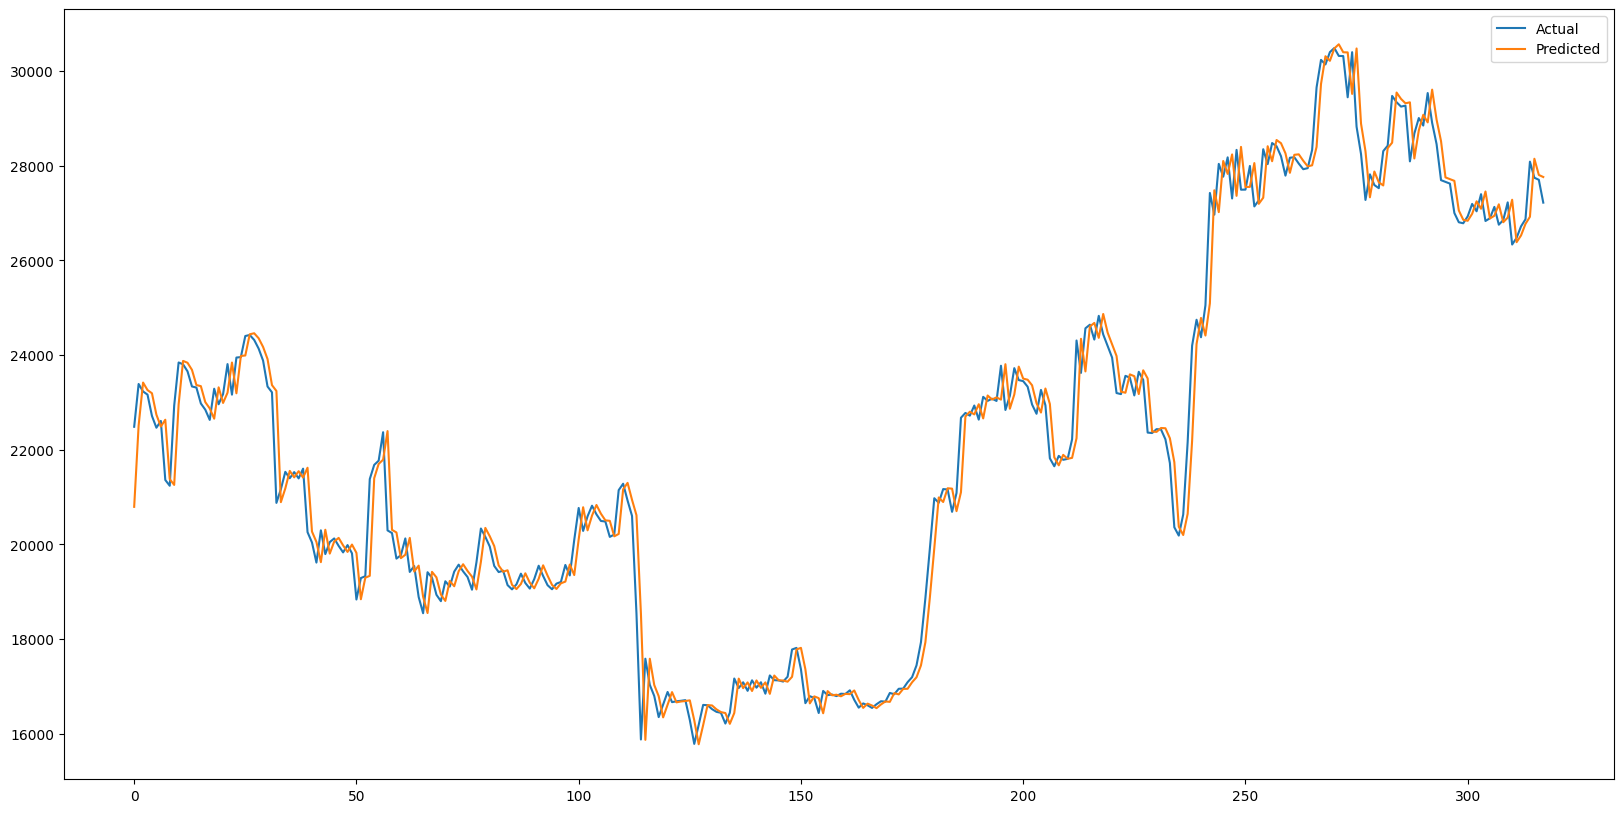

In [18]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [19]:
# Calculating the RMSE and MAE
rmse = np.sqrt(np.mean((test_results_unscaled['Actual'] - test_results_unscaled['Predicted'])**2))
mae = np.mean(np.abs(test_results_unscaled['Actual'] - test_results_unscaled['Predicted']))
rmse, mae

(605.3394752251176, 405.3146097435142)

# 3 Day Look Back Window

In [20]:
x_3.shape, y_3.shape

((3176, 3, 1), (3176, 1))

In [21]:
X_3_train, y_3_train = x_3[:int(0.8*len(x_3))], y_3[:int(0.8*len(x_3))]
X_3_val, y_3_val = x_3[int(0.8*len(x_3)):int(0.9*len(x_3))], y_3[int(0.8*len(x_3)):int(0.9*len(x_3))]
X_3_test, y_3_test = x_3[int(0.9*len(x_3)):], y_3[int(0.9*len(x_3)):]
X_3_train.shape, y_3_train.shape, X_3_val.shape, y_3_val.shape, X_3_test.shape, y_3_test.shape

((2540, 3, 1), (2540, 1), (318, 3, 1), (318, 1), (318, 3, 1), (318, 1))

In [22]:
model_3 = Sequential()
model_3.add(InputLayer(input_shape = (3, 1)))
model_3.add(GRU(64))
model_3.add(Dense(8, activation = 'relu'))
model_3.add(Dense(1, activation = 'linear'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
cp3 = ModelCheckpoint('models/gru_3.h5', save_best_only = True)
model_3.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [24]:
model_3.fit(X_3_train, y_3_train, epochs = 200, validation_data = (X_3_val, y_3_val), callbacks = [cp3])

Epoch 1/200
80/80 [==============================] - 1s 3ms/step - loss: 0.0536 - root_mean_squared_error: 0.2316 - mean_absolute_error: 0.1253 - val_loss: 0.3943 - val_root_mean_squared_error: 0.6279 - val_mean_absolute_error: 0.6035
Epoch 2/200
80/80 [==============================] - 0s 1ms/step - loss: 0.0449 - root_mean_squared_error: 0.2120 - mean_absolute_error: 0.1137 - val_loss: 0.3510 - val_root_mean_squared_error: 0.5925 - val_mean_absolute_error: 0.5677
Epoch 3/200
49/80 [=================>............] - ETA: 0s - loss: 0.0343 - root_mean_squared_error: 0.1852 - mean_absolute_error: 0.0983

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 0s 1ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - mean_absolute_error: 0.1032 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458 - val_mean_absolute_error: 0.5207
Epoch 4/200
80/80 [==============================] - 0s 1ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756 - mean_absolute_error: 0.0919 - val_loss: 0.2356 - val_root_mean_squared_error: 0.4854 - val_mean_absolute_error: 0.4602
Epoch 5/200
80/80 [==============================] - 0s 1ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - mean_absolute_error: 0.0792 - val_loss: 0.1619 - val_root_mean_squared_error: 0.4024 - val_mean_absolute_error: 0.3774
Epoch 6/200
80/80 [==============================] - 0s 1ms/step - loss: 0.0144 - root_mean_squared_error: 0.1202 - mean_absolute_error: 0.0632 - val_loss: 0.0857 - val_root_mean_squared_error: 0.2927 - val_mean_absolute_error: 0.2708
Epoch 7/200
80/80 [==============================] - 0s 1ms/step - loss:

In [25]:
model_3 = load_model('models/gru_3.h5')

In [26]:
test_3_predictions = model_3.predict(X_3_test)
test_3_results = pd.DataFrame({'Actual': y_3_test.flatten(), 'Predicted': test_3_predictions.flatten()})
test_3_results

10/10 [==============================] - 0s 606us/step


,Actual,Predicted
0,0.331028,0.309422
1,0.344439,0.325473
2,0.342099,0.341012
3,0.341103,0.344516
4,0.334431,0.344006
...,...,...
313,0.396064,0.395538
314,0.414128,0.398124
315,0.409086,0.411450
316,0.408440,0.412734


In [27]:
# Creating a dataframe with the actual and predicted values without the scaling
test_3_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_3_test).flatten(), 'Predicted': scaler.inverse_transform(test_3_predictions).flatten()})

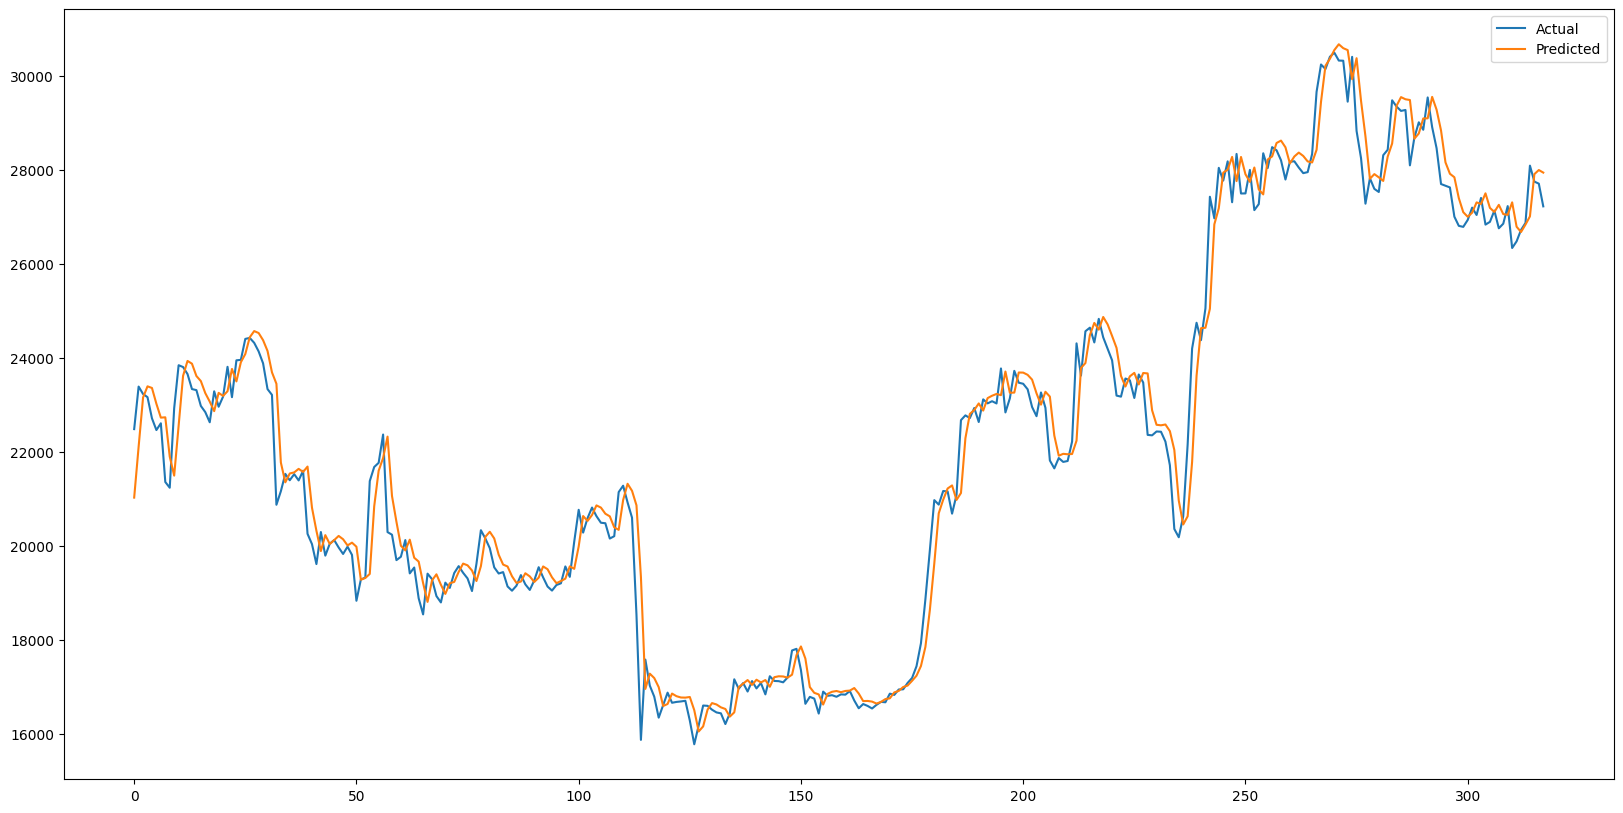

In [28]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_3_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_3_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [29]:
# Calculating the RMSE and MAE
rmse_3 = np.sqrt(np.mean((test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted'])**2))
mae_3 = np.mean(np.abs(test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted']))
rmse_3, mae_3

(652.9549159866707, 442.0913853675315)

# 7 Day Look Back Window

In [30]:
x_7.shape, y_7.shape

((3172, 7, 1), (3172, 1))

In [31]:
X_7_train, y_7_train = x_7[:int(0.8*len(x_7))], y_7[:int(0.8*len(x_7))]
X_7_val, y_7_val = x_7[int(0.8*len(x_7)):int(0.9*len(x_7))], y_7[int(0.8*len(x_7)):int(0.9*len(x_7))]
X_7_test, y_7_test = x_7[int(0.9*len(x_7)):], y_7[int(0.9*len(x_7)):]
X_7_train.shape, y_7_train.shape, X_7_val.shape, y_7_val.shape, X_7_test.shape, y_7_test.shape

((2537, 7, 1), (2537, 1), (317, 7, 1), (317, 1), (318, 7, 1), (318, 1))

In [32]:
model_7 = Sequential()
model_7.add(InputLayer(input_shape = (7, 1)))
model_7.add(GRU(64))
model_7.add(Dense(8, activation = 'relu'))
model_7.add(Dense(1, activation = 'linear'))

model_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
cp7 = ModelCheckpoint('models/gru_7.h5', save_best_only = True)
model_7.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [34]:
model_7.fit(X_7_train, y_7_train, epochs = 200, validation_data = (X_7_val, y_7_val), callbacks = [cp7])

Epoch 1/200
80/80 [==============================] - 1s 4ms/step - loss: 0.0360 - root_mean_squared_error: 0.1897 - mean_absolute_error: 0.1041 - val_loss: 0.1433 - val_root_mean_squared_error: 0.3786 - val_mean_absolute_error: 0.3554
Epoch 2/200
80/80 [==============================] - 0s 2ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - mean_absolute_error: 0.0773 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2355 - val_mean_absolute_error: 0.2192
Epoch 3/200
 1/80 [..............................] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0624

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 0s 2ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - mean_absolute_error: 0.0468 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068 - val_mean_absolute_error: 0.0965
Epoch 4/200
80/80 [==============================] - 0s 2ms/step - loss: 8.5005e-04 - root_mean_squared_error: 0.0292 - mean_absolute_error: 0.0187 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.0267
Epoch 5/200
80/80 [==============================] - 0s 2ms/step - loss: 2.6554e-04 - root_mean_squared_error: 0.0163 - mean_absolute_error: 0.0090 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.0262
Epoch 6/200
80/80 [==============================] - 0s 2ms/step - loss: 2.5535e-04 - root_mean_squared_error: 0.0160 - mean_absolute_error: 0.0084 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.0271
Epoch 7/200
80/80 [==============================] - 0s 2ms/

In [35]:
model_7 = load_model('models/gru_7.h5')

In [36]:
test_7_predictions = model_7.predict(X_7_test)
test_7_results = pd.DataFrame({'Actual': y_7_test.flatten(), 'Predicted': test_7_predictions.flatten()})
test_7_results

10/10 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.331028,0.308117
1,0.344439,0.324499
2,0.342099,0.340982
3,0.341103,0.344600
4,0.334431,0.343498
...,...,...
313,0.396064,0.392839
314,0.414128,0.395811
315,0.409086,0.410220
316,0.408440,0.411831


In [37]:
# Creating a dataframe with the actual and predicted values without the scaling
test_7_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_7_test).flatten(), 'Predicted': scaler.inverse_transform(test_7_predictions).flatten()})

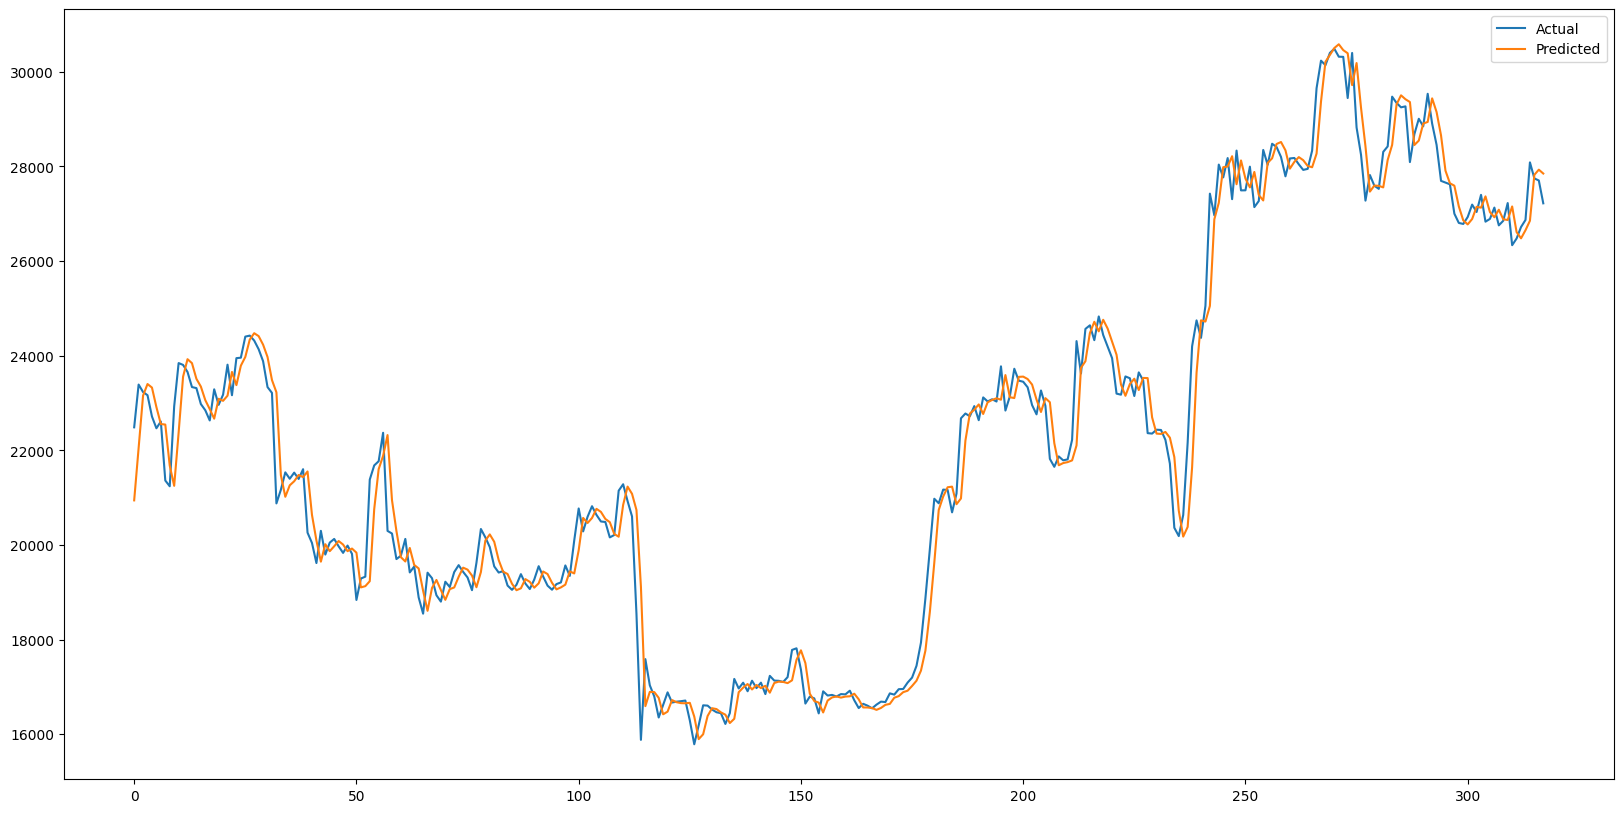

In [38]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_7_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_7_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [39]:
rmse_7 = np.sqrt(np.mean((test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted'])**2))
mae_7 = np.mean(np.abs(test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted']))
rmse_7, mae_7

(634.942066925959, 418.87277970224056)

# 15 Day Look Back Window

In [40]:
x_15.shape, y_15.shape

((3164, 15, 1), (3164, 1))

In [41]:
X_15_train, y_15_train = x_15[:int(0.8*len(x_15))], y_15[:int(0.8*len(x_15))]
X_15_val, y_15_val = x_15[int(0.8*len(x_15)):int(0.9*len(x_15))], y_15[int(0.8*len(x_15)):int(0.9*len(x_15))]
X_15_test, y_15_test = x_15[int(0.9*len(x_15)):], y_15[int(0.9*len(x_15)):]
X_15_train.shape, y_15_train.shape, X_15_val.shape, y_15_val.shape, X_15_test.shape, y_15_test.shape

((2531, 15, 1), (2531, 1), (316, 15, 1), (316, 1), (317, 15, 1), (317, 1))

In [42]:
model_15 = Sequential()
model_15.add(InputLayer(input_shape = (15, 1)))
model_15.add(GRU(64))
model_15.add(Dense(8, activation = 'relu'))
model_15.add(Dense(1, activation = 'linear'))

model_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                12864     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
cp15 = ModelCheckpoint('models/gru_15.h5', save_best_only = True)
model_15.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [44]:
model_15.fit(X_15_train, y_15_train, epochs = 200, validation_data = (X_15_val, y_15_val), callbacks = [cp15])

Epoch 1/200
80/80 [==============================] - 1s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0235 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.0253
Epoch 2/200
53/80 [==================>...........] - ETA: 0s - loss: 1.7632e-04 - root_mean_squared_error: 0.0133 - mean_absolute_error: 0.0063

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 0s 3ms/step - loss: 1.7219e-04 - root_mean_squared_error: 0.0131 - mean_absolute_error: 0.0061 - val_loss: 8.8407e-04 - val_root_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.0226
Epoch 3/200
80/80 [==============================] - 0s 3ms/step - loss: 1.5714e-04 - root_mean_squared_error: 0.0125 - mean_absolute_error: 0.0058 - val_loss: 9.8593e-04 - val_root_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.0242
Epoch 4/200
80/80 [==============================] - 0s 3ms/step - loss: 1.5259e-04 - root_mean_squared_error: 0.0124 - mean_absolute_error: 0.0062 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.0254
Epoch 5/200
80/80 [==============================] - 0s 3ms/step - loss: 1.5185e-04 - root_mean_squared_error: 0.0123 - mean_absolute_error: 0.0069 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.0295
Epoch 6/200
80/80 [=============================

In [45]:
model_15 = load_model('models/gru_15.h5')

In [46]:
test_15_predictions = model_15.predict(X_15_test)
test_15_results = pd.DataFrame({'Actual': y_15_test.flatten(), 'Predicted': test_15_predictions.flatten()})
test_15_results

10/10 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.344439,0.328070
1,0.342099,0.343823
2,0.341103,0.343060
3,0.334431,0.341138
4,0.330729,0.334616
...,...,...
312,0.396064,0.393023
313,0.414128,0.395676
314,0.409086,0.412560
315,0.408440,0.410054


In [47]:
# Creating a dataframe with the actual and predicted values without the scaling
test_15_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_15_test).flatten(), 'Predicted': scaler.inverse_transform(test_15_predictions).flatten()})

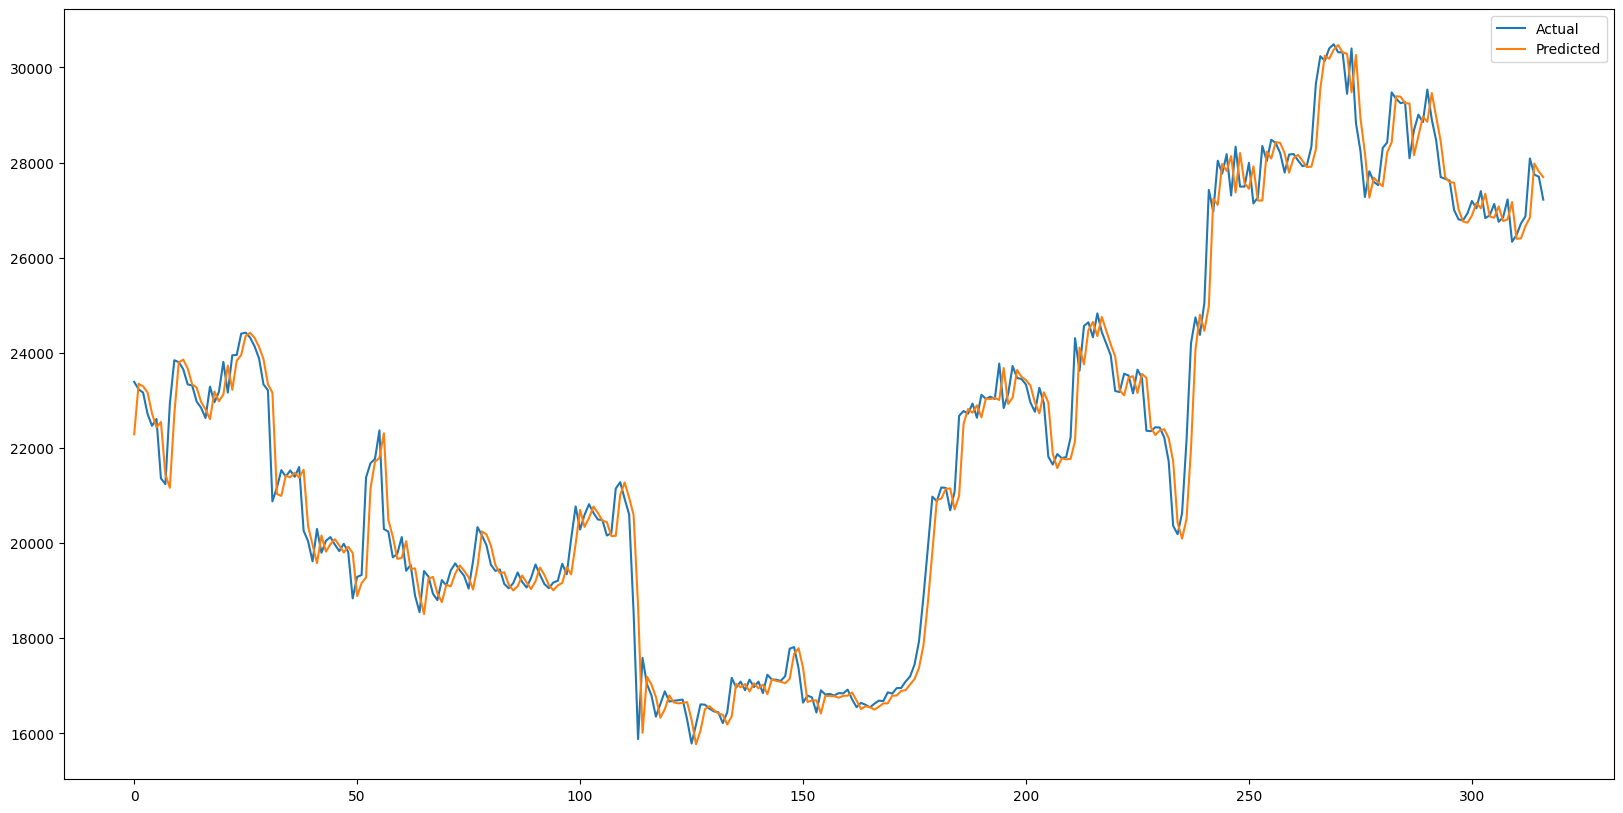

In [48]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_15_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_15_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [49]:
rmse_15 = np.sqrt(np.mean((test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted'])**2))
mae_15 = np.mean(np.abs(test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted']))
rmse_15, mae_15

(603.3309993574996, 398.6281977030757)

# 30 Day Look Back Window

In [50]:
x_30.shape, y_30.shape

((3149, 30, 1), (3149, 1))

In [51]:
X_30_train, y_30_train = x_30[:int(0.8*len(x_30))], y_30[:int(0.8*len(x_30))]
X_30_val, y_30_val = x_30[int(0.8*len(x_30)):int(0.9*len(x_30))], y_30[int(0.8*len(x_30)):int(0.9*len(x_30))]
X_30_test, y_30_test = x_30[int(0.9*len(x_30)):], y_30[int(0.9*len(x_30)):]
X_30_train.shape, y_30_train.shape, X_30_val.shape, y_30_val.shape, X_30_test.shape, y_30_test.shape

((2519, 30, 1), (2519, 1), (315, 30, 1), (315, 1), (315, 30, 1), (315, 1))

In [52]:
model_30 = Sequential()
model_30.add(InputLayer(input_shape = (30, 1)))
model_30.add(GRU(64))
model_30.add(Dense(8, activation = 'relu'))
model_30.add(Dense(1, activation = 'linear'))

model_30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                12864     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
cp30 = ModelCheckpoint('models/gru_30.h5', save_best_only = True)
model_30.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [54]:
model_30.fit(X_30_train, y_30_train, epochs = 200, validation_data = (X_30_val, y_30_val), callbacks = [cp30])

Epoch 1/200
79/79 [==============================] - 1s 8ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - mean_absolute_error: 0.0234 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.0275
Epoch 2/200
31/79 [==========>...................] - ETA: 0s - loss: 2.1757e-04 - root_mean_squared_error: 0.0148 - mean_absolute_error: 0.0078

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 0s 6ms/step - loss: 1.9761e-04 - root_mean_squared_error: 0.0141 - mean_absolute_error: 0.0079 - val_loss: 7.9932e-04 - val_root_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.0212
Epoch 3/200
79/79 [==============================] - 0s 6ms/step - loss: 1.7498e-04 - root_mean_squared_error: 0.0132 - mean_absolute_error: 0.0072 - val_loss: 8.1662e-04 - val_root_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.0217
Epoch 4/200
79/79 [==============================] - 0s 6ms/step - loss: 1.6853e-04 - root_mean_squared_error: 0.0130 - mean_absolute_error: 0.0070 - val_loss: 8.6942e-04 - val_root_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.0226
Epoch 5/200
79/79 [==============================] - 0s 6ms/step - loss: 1.7330e-04 - root_mean_squared_error: 0.0132 - mean_absolute_error: 0.0075 - val_loss: 8.5715e-04 - val_root_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.0224
Epoch 6/200
79/79 [=====================

In [55]:
model_30 = load_model('models/gru_30.h5')

In [56]:
test_30_predictions = model_30.predict(X_30_test)
test_30_results = pd.DataFrame({'Actual': y_30_test.flatten(), 'Predicted': test_30_predictions.flatten()})
test_30_results

10/10 [==============================] - 0s 2ms/step


,Actual,Predicted
0,0.341103,0.340802
1,0.334431,0.339298
2,0.330729,0.333033
3,0.332861,0.328902
4,0.314349,0.330437
...,...,...
310,0.396064,0.391688
311,0.414128,0.394206
312,0.409086,0.410892
313,0.408440,0.408267


In [57]:
# Creating a dataframe with the actual and predicted values without the scaling
test_30_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_30_test).flatten(), 'Predicted': scaler.inverse_transform(test_30_predictions).flatten()})

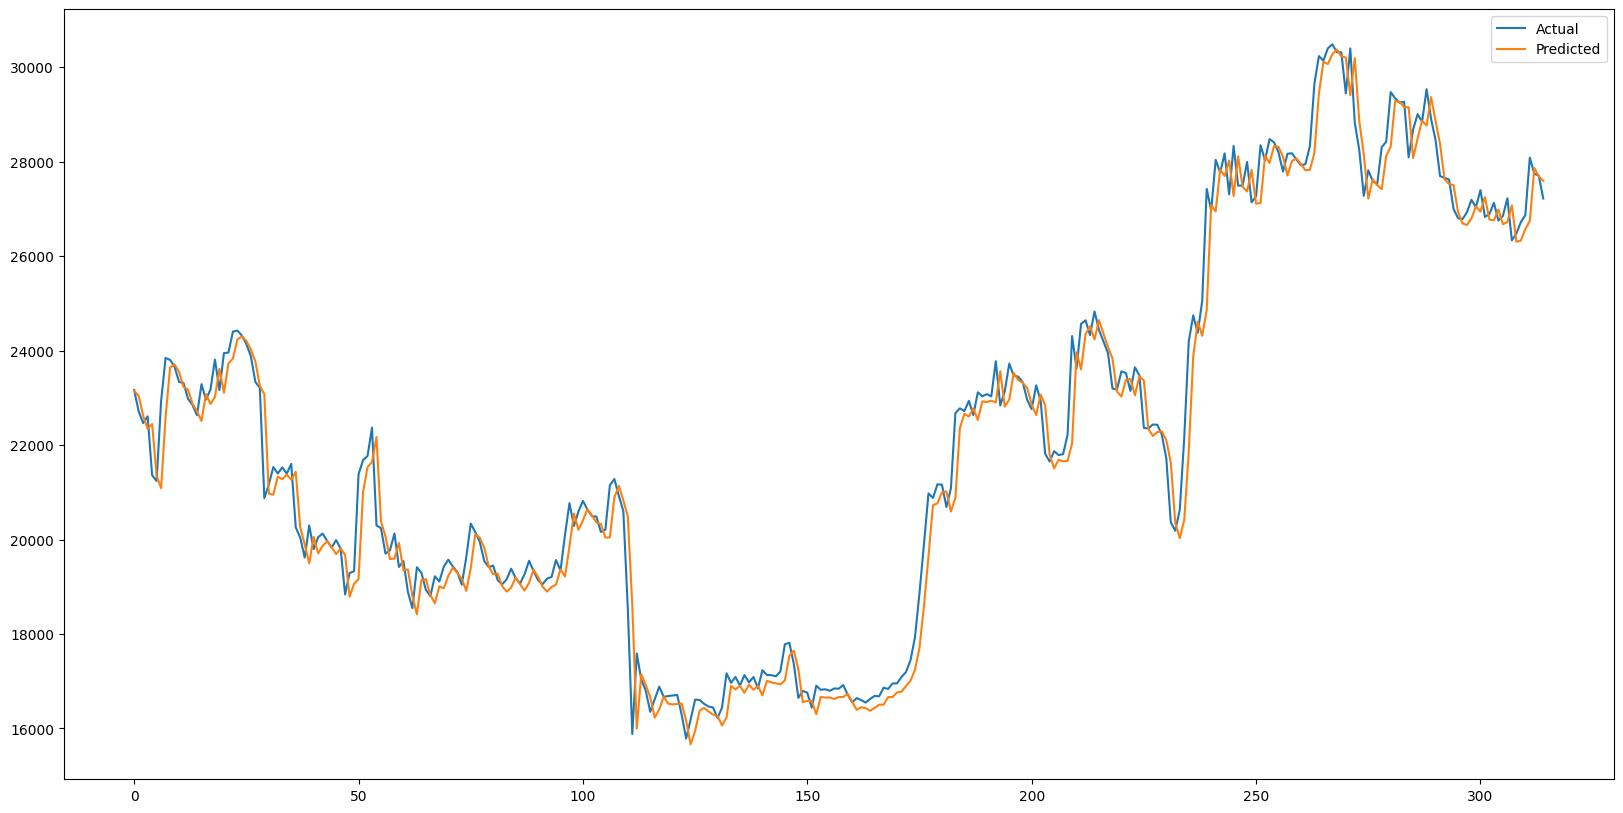

In [58]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_30_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_30_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [59]:
rmse_30 = np.sqrt(np.mean((test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted'])**2))
mae_30 = np.mean(np.abs(test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted']))
rmse_30, mae_30

(622.4226288240383, 415.8841703869048)

# 60 Day Look Back Window

In [60]:
x_60.shape, y_60.shape

((3119, 60, 1), (3119, 1))

In [61]:
X_60_train, y_60_train = x_60[:int(0.8*len(x_60))], y_60[:int(0.8*len(x_60))]
X_60_val, y_60_val = x_60[int(0.8*len(x_60)):int(0.9*len(x_60))], y_60[int(0.8*len(x_60)):int(0.9*len(x_60))]
X_60_test, y_60_test = x_60[int(0.9*len(x_60)):], y_60[int(0.9*len(x_60)):]
X_60_train.shape, y_60_train.shape, X_60_val.shape, y_60_val.shape, X_60_test.shape, y_60_test.shape

((2495, 60, 1), (2495, 1), (312, 60, 1), (312, 1), (312, 60, 1), (312, 1))

In [62]:
model_60 = Sequential()
model_60.add(InputLayer(input_shape = (60, 1)))
model_60.add(GRU(64))
model_60.add(Dense(8, activation = 'relu'))
model_60.add(Dense(1, activation = 'linear'))

model_60.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
cp60 = ModelCheckpoint('models/gru_60.h5', save_best_only = True)
model_60.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [64]:
model_60.fit(X_60_train, y_60_train, epochs = 200, validation_data = (X_60_val, y_60_val), callbacks = [cp60])

Epoch 1/200
78/78 [==============================] - 2s 12ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - mean_absolute_error: 0.0379 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.0244
Epoch 2/200
19/78 [======>.......................] - ETA: 0s - loss: 1.7484e-04 - root_mean_squared_error: 0.0132 - mean_absolute_error: 0.0072

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 1s 10ms/step - loss: 2.0113e-04 - root_mean_squared_error: 0.0142 - mean_absolute_error: 0.0072 - val_loss: 8.0919e-04 - val_root_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.0211
Epoch 3/200
78/78 [==============================] - 1s 10ms/step - loss: 1.9568e-04 - root_mean_squared_error: 0.0140 - mean_absolute_error: 0.0078 - val_loss: 7.3051e-04 - val_root_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.0200
Epoch 4/200
78/78 [==============================] - 1s 10ms/step - loss: 1.7957e-04 - root_mean_squared_error: 0.0134 - mean_absolute_error: 0.0075 - val_loss: 6.6344e-04 - val_root_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.0190
Epoch 5/200
78/78 [==============================] - 1s 10ms/step - loss: 1.4371e-04 - root_mean_squared_error: 0.0120 - mean_absolute_error: 0.0063 - val_loss: 7.1787e-04 - val_root_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.0202
Epoch 6/200
78/78 [=================

In [65]:
model_60 = load_model('models/gru_60.h5')

In [66]:
test_60_predictions = model_60.predict(X_60_test)
test_60_results = pd.DataFrame({'Actual': y_60_test.flatten(), 'Predicted': test_60_predictions.flatten()})

10/10 [==============================] - 0s 2ms/step


In [67]:
# Creating a dataframe with the actual and predicted values without the scaling
test_60_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(y_60_test).flatten(), 'Predicted': scaler.inverse_transform(test_60_predictions).flatten()})
test_60_results_unscaled

,Actual,Predicted
0,22609.164062,22534.365234
1,21361.701172,22614.052734
2,21239.753906,21545.039062
3,22930.548828,21257.501953
4,23843.886719,22703.953125
...,...,...
307,26868.353516,26714.070312
308,28085.646484,26888.878906
309,27745.884766,27997.779297
310,27702.349609,27864.570312


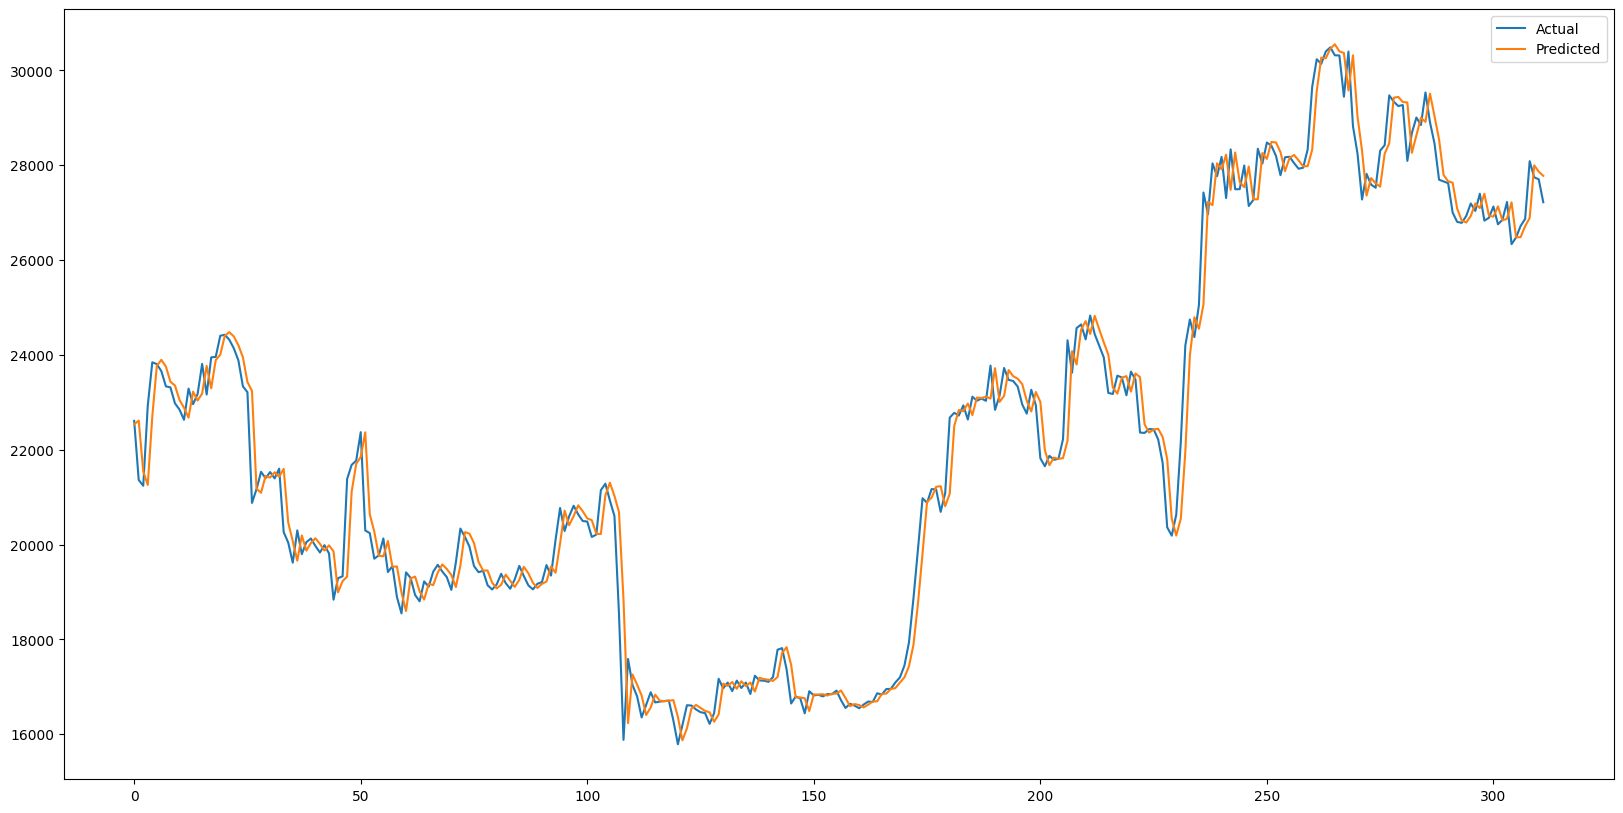

In [68]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_60_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_60_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [69]:
rmse_60 = np.sqrt(np.mean((test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted'])**2))
mae_60 = np.mean(np.abs(test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted']))
rmse_60, mae_60

(605.8483408417703, 399.6695650540866)

# Comparing the models 

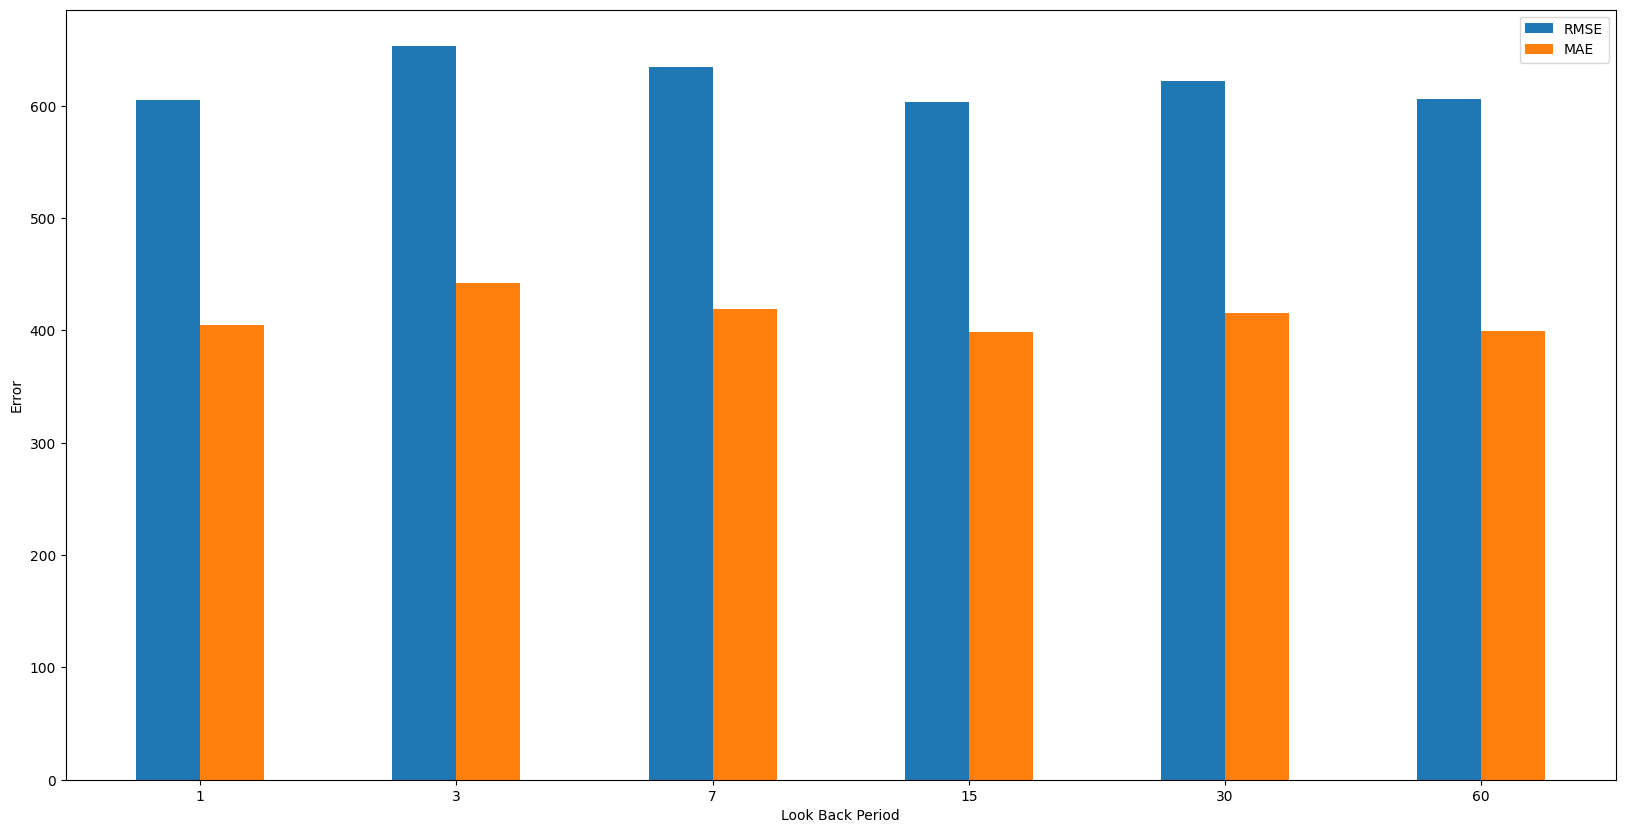

In [70]:
# Plotting in a bar chart, the RMSE and MAE for each look back period. The two metrics are plotted side by side for each look back period
plt.figure(figsize = (20, 10))
plt.bar(np.arange(6), [rmse, rmse_3, rmse_7, rmse_15, rmse_30, rmse_60], width = 0.25, label = 'RMSE')
plt.bar(np.arange(6) + 0.25, [mae, mae_3, mae_7, mae_15, mae_30, mae_60], width = 0.25, label = 'MAE')
plt.xticks(np.arange(6) + 0.125, ['1', '3', '7', '15', '30', '60'])
plt.xlabel('Look Back Period')
plt.ylabel('Error')
plt.legend()